# Postprocessing pipeline with SpikeInterface

In [1]:
def get_meta_data(ext):
    meta_data_dict = {
        'DT2': {'num_channels': 32, 'num_adc_bits': 16, 'voltage_res': 0.2e-6, 'sampling_rate': 32e3},
        'DT4': {'num_channels': 64, 'num_adc_bits': 16, 'voltage_res': 0.2e-6, 'sampling_rate': 32e3},
        'DT6': {'num_channels': 128, 'num_adc_bits': 16, 'voltage_res': 0.2e-6, 'sampling_rate': 32e3},
        'DT8': {'num_channels': 8, 'num_adc_bits': 15, 'voltage_res': 0.42e-6, 'sampling_rate': 4e3},
        'DAT': {'num_channels': 16, 'num_adc_bits': 12, 'voltage_res': 3.3e-6, 'sampling_rate': 31.25e3}
    }
    return meta_data_dict[ext.upper()]

In [12]:
# ===========================================================================
# Testing the postprocessing pipeline analyses for the sorted Wifi_20240430 session with kilosort4
# ===========================================================================
import spikeinterface as si


import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

# Loading the bin data 
file_path = Path(r"C:\Users\boninilab\Desktop\kilosort-test\sorting-test-Wifi_20240430\binary_files\Wifi_20240430_good_heatmap.bin")

# Confirm file existence
assert file_path.is_file(), f"Error: {file_path} is not a valid file. Please check the path."

# Define recording parameters
sampling_frequency = 32000.0  
num_channels = 128  
dtype = "uint16"
gain_to_uV = 0.2
offset_to_uV = - 2 ** (16 - 1) * gain_to_uV

# Load data using SpikeInterface
recording = si.read_binary(
    file_paths=file_path,
    sampling_frequency=sampling_frequency,
    num_channels=num_channels,
    dtype=dtype,
    gain_to_uV=gain_to_uV,
    offset_to_uV=offset_to_uV
)

# Load the probe configuration
from probeinterface import read_prb

probe_file = Path("wifi_channel_map_kilosort.prb")
probe = read_prb(probe_file)

recording.set_probegroup(probe, in_place=True)

recording

BinaryRecordingExtractor: 128 channels - 32.0kHz - 1 segments - 128,791,427 samples 
                          4,024.73s (1.12 hours) - uint16 dtype - 30.71 GiB
  file_paths: ['C:\\Users\\boninilab\\Desktop\\kilosort-test\\sorting-test-Wifi_20240430\\binary_files\\Wifi_20240430_good_heatmap.bin']

In [13]:
# Load the sorting result from kilosort4/phy
from spikeinterface.extractors import read_phy

sorting_path = Path(r"C:\Users\boninilab\Desktop\kilosort-test\sorting-test-Wifi_20240430\kilosort4_output_tests\Wifi_20240430_test4")
sorting = read_phy(sorting_path, exclude_cluster_groups=['noise', 'mua'])
sorting

PhySortingExtractor: 31 units - 1 segments - 32.0kHz

In [14]:
# Create the SortingAnalyzer
analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=recording,
    sparse=False, # default
    format="memory", # default
)
print(analyzer)

SortingAnalyzer: 128 channels - 31 units - 1 segments - memory - has recording
Loaded 0 extensions


In [15]:
ms_before = 1.0
ms_after = 2.0

job_kwargs = dict(n_jobs=8, chunk_duration="1s", progress_bar=True)
compute_dict = {
    'random_spikes': {'method': 'uniform', 'max_spikes_per_unit': 1000},
    'waveforms': {'ms_before': 1.0, 'ms_after': 2.0},
    'templates': {'operators': ["average", "median", "std"]}
}
analyzer.compute(compute_dict, **job_kwargs)

analyzer

compute_waveforms (workers: 8 processes):   0%|          | 0/4025 [00:00<?, ?it/s]

SortingAnalyzer: 128 channels - 31 units - 1 segments - memory - has recording
Loaded 3 extensions: random_spikes, waveforms, templates

In [16]:
# Recompute the analyzer with sparsity enabled
sparsity = si.compute_sparsity(analyzer, method="best_channels")
analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=recording,
    sparsity=sparsity, # default
    format="memory", # default
)

ms_before = 1.0
ms_after = 2.0

job_kwargs = dict(n_jobs=8, chunk_duration="1s", progress_bar=True)
compute_dict = {
    'random_spikes': {'method': 'uniform', 'max_spikes_per_unit': 1000},
    'waveforms': {'ms_before': 1.0, 'ms_after': 2.0},
    'templates': {'operators': ["average", "median", "std"]}}
analyzer.compute(compute_dict, **job_kwargs)

analyzer

compute_waveforms (workers: 8 processes):   0%|          | 0/4025 [00:00<?, ?it/s]

SortingAnalyzer: 128 channels - 31 units - 1 segments - memory - sparse - has recording
Loaded 3 extensions: random_spikes, waveforms, templates

In [21]:
ext_templates = analyzer.get_extension("templates")

av_templates = ext_templates.get_data(operator="average")
print("Templates shape: ", av_templates.shape)

Templates shape:  (31, 96, 128)


In [18]:
cluster_ids = sorting.get_unit_ids()

# for cluster_id in cluster_ids:
#     for 

cluster_ids

array([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 13, 14, 16, 18, 20, 22, 24, 25,
       28, 29, 32, 33, 34, 35, 36, 37, 40, 43, 44, 47, 48, 49])

array([48])

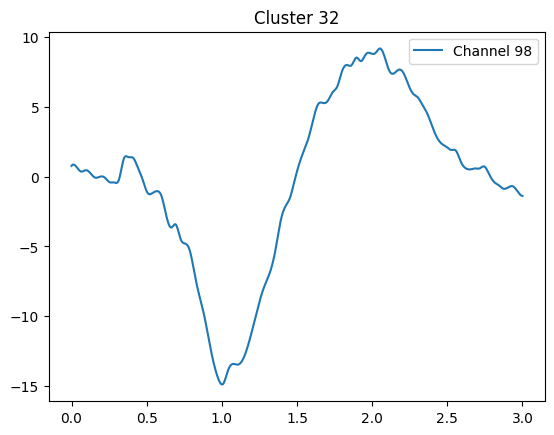

In [33]:
cluster_ids = sorting.get_unit_ids()
unit_id = 32
channel_id = 98

fig, ax = plt.subplots()
unit_index = np.where(np.array(cluster_ids) == unit_id)[0][0]
template = av_templates[unit_index]

from scipy.interpolate import interp1d

# Define original and target time points
npoints = 1000
original_times = np.linspace(0., 3., 96)  # Original 96 points
target_times = np.linspace(0., 3., npoints)  # Target 1000 points

# Create interpolation function (cubic gives smoother results)
f = interp1d(original_times, template[:,channel_id], kind='cubic')
# Apply interpolation to get upsampled waveform
template_upsampled = f(target_times)

wf_times = np.linspace(0., 3., npoints)

ax.plot(wf_times, template_upsampled, label=f"Channel {channel_id}")
ax.set_title(f"Cluster {unit_id}")
plt.legend()

In [31]:
analyzer.compute(input="template_metrics", upsampling_factor=100)

c:\Users\boninilab\miniconda3\envs\spikeinterface\Lib\site-packages\scipy\stats\_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\boninilab\miniconda3\envs\spikeinterface\Lib\site-packages\scipy\stats\_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\boninilab\miniconda3\envs\spikeinterface\Lib\site-packages\scipy\stats\_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [25]:
spk_times = sorting.get_unit_spike_train(unit_id=1, return_times=True)

In [27]:
spk_times[333:350]

array([204.72109375, 211.0305    , 211.08978125, 211.1665625 ,
       211.51965625, 211.62140625, 211.75625   , 213.0785    ,
       213.13778125, 213.2145625 , 213.56765625, 213.66940625,
       213.80425   , 219.625625  , 220.299625  , 220.36078125,
       221.67359375])